In [1]:
import os,sys,string, time
import matplotlib.pyplot as plt
import numpy as np
import uproot
import pandas as pd
from platform import python_version
import scipy
from scipy import stats
import uproot3
import math
from matplotlib.patches import Rectangle
import xgboost
from xgboost import XGBClassifier
import joblib
import seaborn as sns
from importlib import reload
import pickle
import json

import Utilities.Plotter as PT
import Utilities.Constants as Constants
import Utilities.Variables_list as Variables
import Utilities.Functions as Functions
from Utilities.ipython_exit import exit

print ('Success')


Success


## Purpose

This notebook is for training BDT models using xgboost. The BDT models are then saved and will be loaded in notebook 3.5. <br>
The notebook also contains some optimization and performance plotting. With the standard hyper-parameters used for the analysis there is some over-training but when I initially performed the analysis I didn't think it was severe enough to be concerned with. Since the test and training samples are completely separated then any overtraining does not make the result incorrect, it just reduced the separation power of the models. 

## Reading in files

In [2]:
Params = {"Run":"run3", #The run number, so far either "run1" or "run3"
          "Load_single_file":False, #This will override everything else, put the desired file in the "single_file" line
          "single_file":10,
          "Load_standard":True,
          "Load_DetVars":False,
          "Only_keep_common_DetVar_evs":True,
          "Load_data":False,
          "FLATTEN":True, #Have one row per reconstructed object in the analysis dataframe
          "only_presel":False, #Create small files containing only variables necessary for pre-selection, for making pre-selection plots
          "EXT_in_training":True,
          "dirt_in_training":True,
          "Load_pi0_signal":True} #Otherwise loads e+e- samples by default

loc_pkls = "pkl_files/"+Params["Run"]+"/current_files/my_vars/"

In [7]:
signal_samples_dict = {}
# end_string = "_FINAL"
end_string = "_full_Finished" #Is this the final BDT we used?

Presel_overlay = pd.read_pickle(loc_pkls+"Preselected_overlay_"+Params["Run"]+f"_flattened{end_string}.pkl")

#Always load in EXT, dirt for pre-selection, even though might not be used in the training
Presel_EXT = pd.read_pickle(loc_pkls+"Preselected_beamoff_"+Params["Run"]+f"_flattened{end_string}.pkl")
Presel_dirt = pd.read_pickle(loc_pkls+"Preselected_dirtoverlay_"+Params["Run"]+f"_flattened{end_string}.pkl")

start_load_str = loc_pkls
if Params["Load_pi0_signal"] == False: HNL_samples = Constants.HNL_ee_samples_names
if Params["Load_pi0_signal"] == True: 
    start_load_str += f"pi0_selection/"
    HNL_samples = Constants.HNL_mass_pi0_samples_names
if Params["Load_single_file"] == True: HNL_samples = [Params["single_file"]]
    
for HNL_mass in HNL_samples:
    Presel_signal = pd.read_pickle(start_load_str+f"Preselected_{HNL_mass}_"+Params["Run"]+f"_flattened{end_string}.pkl")
    signal_samples_dict[HNL_mass] = Presel_signal

print("overlay events: "+str(len(Presel_overlay)))
print("beamoff events: "+str(len(Presel_EXT)))
print("dirt events: "+str(len(Presel_dirt)))
print(Presel_overlay.keys())

overlay events: 29905
beamoff events: 12184
dirt events: 3095
Index(['run', 'sub', 'evt', 'nslice', 'n_pfps', 'n_tracks', 'n_showers',
       'swtrig_pre', 'swtrig_post', 'trk_sce_start_x_v', 'trk_sce_start_y_v',
       'trk_sce_start_z_v', 'trk_sce_end_x_v', 'trk_sce_end_y_v',
       'trk_sce_end_z_v', 'shr_theta_v', 'shr_phi_v', 'shr_px_v', 'shr_py_v',
       'shr_pz_v', 'shrclusdir0', 'shrclusdir1', 'shrclusdir2',
       'shr_energy_tot', 'trk_theta_v', 'trk_phi_v', 'trk_dir_x_v',
       'trk_dir_y_v', 'trk_dir_z_v', 'trk_energy', 'trk_energy_hits_tot',
       'trk_energy_tot', 'trk_score_v', 'trk_calo_energy_u_v', 'trk_end_x_v',
       'trk_chipr_best', 'pfnplanehits_U', 'pfnplanehits_V', 'pfnplanehits_Y',
       'NeutrinoEnergy2', 'SliceCaloEnergy2', 'nu_flashmatch_score',
       'contained_sps_ratio', 'flash_time', 'contained_fraction', 'trk_score',
       'crtveto', 'shr_tkfit_dedx_U', 'shr_tkfit_dedx_V', 'shr_tkfit_dedx_Y',
       'shr_tkfit_dedx_max', 'shr_tkfit_2cm_dedx_Y', '

## Calculating fractions of tracks and showers

In [ ]:
for HNL_mass in HNL_samples:
    print(type(signal_samples_dict[HNL_mass]['shr_px_v'])) 
    
#dataframe[dataframe['Percentage'] > 70]

In [ ]:
test_mass = "10_ee"

print("Total events: " + str(len(signal_samples_dict[HNL_mass]['n_pfps'])))

zero_showers = len(signal_samples_dict[HNL_mass][signal_samples_dict[HNL_mass]['n_showers']==0])
zero_tracks = len(signal_samples_dict[HNL_mass][signal_samples_dict[HNL_mass]['n_tracks']==0])

print(f"Zero showers in: {zero_showers}")
print(f"Zero tracks in: {zero_tracks}")

var_list = ['shr_theta_v', 'shr_phi_v', 'shr_pz_v', 'trk_theta_v', 'trk_phi_v', 'trk_dir_z_v']

for var in var_list:
    non_reco = signal_samples_dict[HNL_mass][signal_samples_dict[HNL_mass][var]==-9999.0]
    print(var+": "+str(len(non_reco)))


print()

var_list_2 = ['shrclusdir2', 'shr_energy_tot','trk_energy', 'trk_energy_tot','shr_tkfit_dedx_max']

for var in var_list_2:
    non_reco = signal_samples_dict[HNL_mass][signal_samples_dict[HNL_mass][var]==-9999.0]
    print(var+": "+str(len(non_reco)))
    

In [ ]:
# print(signal_samples_dict[HNL_mass]['rse_id'])
zero_showers_df = signal_samples_dict[HNL_mass][signal_samples_dict[HNL_mass]['n_showers']==0]
one_shower_df = signal_samples_dict[HNL_mass][signal_samples_dict[HNL_mass]['n_showers']==1]
no_shr_energy_tot_df = signal_samples_dict[HNL_mass][signal_samples_dict[HNL_mass]['shr_energy_tot']==-9999]
no_shr_tkfit_df = signal_samples_dict[HNL_mass][signal_samples_dict[HNL_mass]['shr_tkfit_dedx_max']==-9999]

filtered_shrs = zero_showers_df.loc[(zero_showers_df['rse_id'].isin(no_shr_energy_tot_df['rse_id']))]
filtered_shrs_inv = no_shr_energy_tot_df.loc[-(no_shr_energy_tot_df['rse_id'].isin(zero_showers_df['rse_id']))]

filtered_shr_tkfit = zero_showers_df.loc[(zero_showers_df['rse_id'].isin(no_shr_tkfit_df['rse_id']))]

print(len(filtered_shrs))
print(len(filtered_shrs_inv))
print(len(filtered_shr_tkfit))

In [ ]:
print(len(filtered_shrs_inv[filtered_shrs_inv["n_showers"]==1]))

In [ ]:
print(len(filtered_shrs_inv[filtered_shrs_inv["trk_score_v"]>0.5]))

In [ ]:
non_reco_shr = signal_samples_dict[HNL_mass][signal_samples_dict[HNL_mass]['shr_phi_v']==-9999.0] # 'shr_pz_v'
non_reco_trk = signal_samples_dict[HNL_mass][signal_samples_dict[HNL_mass]['trk_phi_v']==-9999.0]
non_reco_energy = signal_samples_dict[HNL_mass][signal_samples_dict[HNL_mass]['NeutrinoEnergy2']==-9999.0]
non_reco_shrclusdir = signal_samples_dict[HNL_mass][signal_samples_dict[HNL_mass]['shrclusdir2']==-9999.0] 
non_reco_trkcalo = signal_samples_dict[HNL_mass][signal_samples_dict[HNL_mass]['trk_calo_energy_u_v']==-9999.0] 
non_reco_trk_E_tot = signal_samples_dict[HNL_mass][signal_samples_dict[HNL_mass]['trk_energy_tot']==-9999.0] 

print(len(signal_samples_dict[HNL_mass]))
print(len(non_reco_shr))
print(len(non_reco_trk))
print(len(non_reco_energy))
print(len(non_reco_shrclusdir))
print(len(non_reco_trkcalo))
print(len(non_reco_trk_E_tot))

In [ ]:
print(len(signal_samples_dict[HNL_mass][signal_samples_dict[HNL_mass]['n_tracks']==0]))

In [ ]:
print(len(signal_samples_dict[HNL_mass][signal_samples_dict[HNL_mass]['n_showers']==0]))

## Splitting into test and training samples

In [8]:
#overlay_train_frac, signal_train_frac, EXT_train_frac
overlay_train_frac = 0.5 
signal_train_frac = 0.7
EXT_train_frac = 0.5
dirt_train_frac = 0.5

split_dict = Functions.Split_samples(Presel_overlay, signal_samples_dict, Presel_EXT, Presel_dirt, 
                                     overlay_train_frac, signal_train_frac, EXT_train_frac, dirt_train_frac)

overlay_test, overlay_train = split_dict["overlay_test"], split_dict["overlay_train"]
signal_test_dict, signal_train_dict = split_dict["signal_test_dict"], split_dict["signal_train_dict"]
EXT_test, EXT_train = split_dict["EXT_test"], split_dict["EXT_train"]
dirt_test, dirt_train = split_dict["dirt_test"], split_dict["dirt_train"]


Length overlay train 14952
Length overlay test 14953
Length EXT train 6092
Length EXT test 6092
Length dirt train 1547
Length dirt test 1548
Length 150_pi0 train 11704
Length 150_pi0 test 5016
Length 180_pi0 train 11307
Length 180_pi0 test 4846
Length 200_pi0 train 11095
Length 200_pi0 test 4755
Length 220_pi0 train 10982
Length 220_pi0 test 4707
Length 240_pi0 train 11198
Length 240_pi0 test 4800
Length 245_pi0 train 10712
Length 245_pi0 test 4592


In [9]:
ultimate_feature_list = ['n_pfps', 'n_tracks', 'shr_theta_v', 'shr_phi_v', 'shr_pz_v', 'shrclusdir2', 'shr_energy_tot',
                         'trk_theta_v', 'trk_phi_v','trk_dir_z_v', 'trk_energy', 'trk_energy_tot', 'trk_score_v',
                         'pfnplanehits_U', 'pfnplanehits_V', 'pfnplanehits_Y', 'NeutrinoEnergy2']#, 'nu_flashmatch_score']

ultimate_feature_list += ['shr_tkfit_dedx_max', 'topological_score']
if Params["Run"]=="run3":
    ultimate_feature_list += ['nu_flashmatch_score']
print(f"Number of features is {len(ultimate_feature_list)}")

bdt_vars = ultimate_feature_list #This is using just the most important variables list

if Params["Load_pi0_signal"] == False: BDT_name = f"{end_string}"
if Params["Load_pi0_signal"] == True: BDT_name = f"{end_string}"
if Params["EXT_in_training"] == True: BDT_name = f"{end_string}"

BDT_name = "_full_Finished_10"
# BDT_name = "_full_Finished_8" #For pi0 importances plot

var_list = bdt_vars
train_frac_dict = {"overlay":overlay_train_frac, "signal":signal_train_frac, "beamoff":EXT_train_frac, "dirtoverlay":dirt_train_frac}

start_loc = f"bdts/"
if Params["Load_pi0_signal"] == True: start_loc += "pi0_selection/"

save_vars_fracs = input("Do you want to save the variables and training fractions? y/n ")

if save_vars_fracs == "y":
    print(f"Saving variables used as {BDT_name}_"+Params["Run"]+".pkl")
    with open(start_loc+f"input_vars/{BDT_name}_"+Params["Run"], "wb") as fp:   #Pickling
        pickle.dump(var_list, fp)

    print(f"Saving training fractions used as {BDT_name}_"+Params["Run"]+".pkl")
    with open(start_loc+f"Training_fractions/{BDT_name}_"+Params["Run"], "wb") as fp:   #Pickling
        pickle.dump(train_frac_dict, fp)

signal_samples_dict.keys()

Number of features is 20


Do you want to save the variables and training fractions? y/n  n


dict_keys(['150_pi0', '180_pi0', '200_pi0', '220_pi0', '240_pi0', '245_pi0'])

In [10]:
save_pkls = input("Do you want to save the test sample pkls? y/n ")

if save_pkls == "y":
    Functions.Save_test_pkls(Params, loc_pkls, "_full_Finished_10", overlay_test, signal_test_dict, EXT_test, dirt_test)
else: print("Not saved .pkls")

Do you want to save the test sample pkls? y/n  n


Not saved .pkls


In [11]:
reload(Functions)
combined_dict, labels_dict, bkg_train = Functions.Make_train_labels_and_dicts(Params, bdt_vars, overlay_train, EXT_train, dirt_train, signal_train_dict)

if Params["EXT_in_training"] == True:
    print("Adding EXT events into test set")
    bkg_test = pd.concat([overlay_test,EXT_test])
else: bkg_test = overlay_test.copy()

if Params["dirt_in_training"] == True:
    print("Adding dirt events into test set")
    bkg_test = pd.concat([bkg_test,EXT_test])


Adding EXT events into test set
Adding dirt events into test set


In [12]:
def Test_vs_train_plots(test_sig, test_bkg, train_sig, train_bkg, bdt_dict, bins_dict, ymax=[], xlims=[], legsize=16, sig_region=3):
    """
    Plotting the BDT score results for test and training sets to check for overtraining.
    """
    test_results_sig_dict, test_results_bkg_dict = {}, {}
    train_results_sig_dict, train_results_bkg_dict = {}, {}
    
    frac_test_signal, frac_train_signal = {}, {}
    frac_test_bkg, frac_train_bkg = {}, {}
    
    for HNL_mass in test_sig:
        results_sig = Functions.logit(bdt_dict[HNL_mass].predict(test_sig[HNL_mass]))
        results_bkg = Functions.logit(bdt_dict[HNL_mass].predict(test_bkg))

        train_results_sig = Functions.logit(bdt_dict[HNL_mass].predict(train_sig[HNL_mass]))
        train_results_bkg = Functions.logit(bdt_dict[HNL_mass].predict(train_bkg))

        test_results_sig_dict.update({HNL_mass:results_sig})
        test_results_bkg_dict.update({HNL_mass:results_bkg})

        train_results_sig_dict.update({HNL_mass:train_results_sig})
        train_results_bkg_dict.update({HNL_mass:train_results_bkg})

    save = input(f"Do you want to save these plots? y/n")
    for HNL_mass in test_sig:
        plt.figure(figsize=(10,7))
        mass_label=HNL_mass.split("_")[0]
        sample_type = HNL_mass.split("_")[1]
        if sample_type == "ee": full_label = f"{mass_label} MeV " + r"$e^{+}e^{-}$"
        if sample_type == "pi0": full_label = f"{mass_label} MeV " + r"$\nu \pi^{0}$"
        weights_train = np.ones(len(train_results_sig_dict[HNL_mass]))/len(train_results_sig_dict[HNL_mass])
        weights_test = np.ones(len(test_results_sig_dict[HNL_mass]))/len(test_results_sig_dict[HNL_mass])
        # plt.hist(train_results_sig_dict[HNL_mass],bins=bins_dict[HNL_mass], density=True,alpha=0.4,color='red',label=f'Train '+full_label)
        plt.hist(train_results_sig_dict[HNL_mass],bins=bins_dict[HNL_mass], density=False, weights=weights_train,
                 alpha=0.35,color='red',label=f'Train '+full_label)
        # counts,bin_edges = np.histogram(test_results_sig_dict[HNL_mass],bins=bins_dict[HNL_mass],density=True)
        counts,bin_edges = np.histogram(test_results_sig_dict[HNL_mass],bins=bins_dict[HNL_mass],density=False, weights=weights_test)
        bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
        
        #For calculating the fraction in the signal region
        x_train, y_train = np.histogram(train_results_sig_dict[HNL_mass],bins=bins_dict[HNL_mass],range=xlims,density=True)
        
        # Taken from plotting script
        x,y=np.histogram(test_results_sig_dict[HNL_mass],bins=bins_dict[HNL_mass],range=xlims,density=True)
        x1,y=np.histogram(test_results_sig_dict[HNL_mass],bins=bins_dict[HNL_mass],range=xlims)
        bin_center = [(y[i] + y[i+1])/2. for i in range(len(y)-1)]
        dat_val=x
        # dat_err=np.sqrt(x1)*Functions.safe_div(x,x1) #need to write one for arrays instead of single values.
        dat_err=np.sqrt(x1)*np.nan_to_num(x/x1)
        
        # plt.plot(bin_centers,counts,marker='o',linestyle="None",color='red',label=f'Test '+full_label)
        plt.errorbar(bin_center,dat_val,yerr=dat_err,fmt='.',color='red',
                     markersize=9,lw=5,capsize=6,elinewidth=3,label=f'Test '+full_label)

        plt.hist(train_results_bkg_dict[HNL_mass], bins=bins_dict[HNL_mass], density = True, alpha = 0.35, color = 'orange', label = r'Train background')
        counts,bin_edges = np.histogram(test_results_bkg_dict[HNL_mass],bins=bins_dict[HNL_mass],density = True)
        bin_centers = (bin_edges[:-1] +  bin_edges[1:])/2.
        
        x_bkg,y_bkg=np.histogram(test_results_bkg_dict[HNL_mass],bins=bins_dict[HNL_mass],range=xlims,density=True)
        x1_bkg,y_bkg=np.histogram(test_results_bkg_dict[HNL_mass],bins=bins_dict[HNL_mass],range=xlims)
        bin_center_bkg = [(y[i] + y[i+1])/2. for i in range(len(y)-1)]
        dat_val_bkg=x_bkg
        dat_err_bkg=np.sqrt(x1_bkg)*np.nan_to_num(x_bkg/x1_bkg)
        
        x_train_bkg, y_train_bkg = np.histogram(train_results_bkg_dict[HNL_mass],bins=bins_dict[HNL_mass],range=xlims,density=True)
        
        # plt.plot(bin_centers,counts,marker='o',linestyle ="None",color='orange',label = r'Test background')
        plt.errorbar(bin_center_bkg,dat_val_bkg,yerr=dat_err_bkg,fmt='.',color='orange',
                     markersize=9,lw=5,capsize=6,elinewidth=3,label=r'Test background')
        
        #calculating test and train fracs in signal region
        frac_test_signal[HNL_mass] = sum(x[-1*sig_region:])
        frac_train_signal[HNL_mass] = sum(x_train[-1*sig_region:])
        frac_test_bkg[HNL_mass] = sum(x_bkg[-1*sig_region:])
        frac_train_bkg[HNL_mass] = sum(x_train_bkg[-1*sig_region:])
        
        if ymax != []:
            plt.ylim(0, ymax)
        if xlims != []:
            plt.xlim(xlims)
        
        plt.xlabel(f'BDT Score '+r'($m_{\mathrm{HNL}}=$'+f'{mass_label} MeV)', fontsize=30)
        plt.ylabel("Fraction of events")
        plt.legend(fontsize=legsize, ncol=2)
        
        if(save=="y"): 
            plt.savefig(f"plots/BDT_output/test_vs_train/Test_vs_train_" + Params["Run"] + f"_{HNL_mass}{BDT_name}.png")
            plt.savefig(f"plots/BDT_output/test_vs_train/Test_vs_train_" + Params["Run"] + f"_{HNL_mass}{BDT_name}.pdf")
            
    return frac_test_signal, frac_train_signal, frac_test_bkg, frac_train_bkg
    
        
def bkg_test_dists(overlay, beamoff, dirt, bdt_dict, bins_dict, sample_norms):
    """
    Just plotting histograms of the output scores of test sets.
    Correctly normalised by sample_norms.
    """
    for HNL_mass in bdt_dict:
        results_overlay = Functions.logit(bdt_dict[HNL_mass].predict(overlay))
        results_beamoff = Functions.logit(bdt_dict[HNL_mass].predict(beamoff))
        results_dirt = Functions.logit(bdt_dict[HNL_mass].predict(dirt))
        
        weights_overlay = np.ones(len(results_overlay))*sample_norms["overlay"]
        weights_beamoff = np.ones(len(results_beamoff))*sample_norms["beamoff"]
        weights_dirt = np.ones(len(results_dirt))*sample_norms["dirtoverlay"]
        
        plt.figure(figsize=(10,7))
        
        plt.hist(results_overlay,bins=bins_dict[HNL_mass], weights=weights_overlay, density=False,alpha=0.4,label=f'Overlay')
        plt.hist(results_beamoff,bins=bins_dict[HNL_mass], weights=weights_beamoff,density=False,alpha=0.4,label=f'Beamoff')
        plt.hist(results_dirt,bins=bins_dict[HNL_mass], weights=weights_dirt,density=False,alpha=0.4,label=f'dirt')
        
        plt.legend()
    print("overlay sum weights: "+str(sum(weights_overlay)))
    print("beamoff sum weights: "+str(sum(weights_beamoff)))
    print("dirt sum weights: "+str(sum(weights_dirt)))
    

In [13]:
xgb_train_dict, xgb_sig_train_dict, xgb_sig_test_dict, xgb_train_bkg, xgb_test_bkg = Functions.Prepare_for_xgb(Params, bdt_vars, combined_dict, 
                                                                                                     signal_train_dict, bkg_train,  signal_test_dict, 
                                                                                                     bkg_test, labels_dict, missing=-9999.0)


In [14]:
combined_test_dict, labels_test_dict={}, {}
for HNL_mass in xgb_sig_train_dict:
    combined_test_dict[HNL_mass] = pd.concat([signal_test_dict[HNL_mass][bdt_vars], bkg_test[bdt_vars]])
    labels_test_dict[HNL_mass] = [1]*len(signal_test_dict[HNL_mass]) + [0]*len(bkg_test)

xgb_combined_test_dict = {}
for HNL_mass in xgb_sig_train_dict:
    xgb_combined_test_dict[HNL_mass] = xgboost.DMatrix(combined_test_dict[HNL_mass][bdt_vars], label=labels_test_dict[HNL_mass], 
                                                   missing=-9999.0, feature_names=bdt_vars)

In [ ]:
xgb_param = {'booster': 'dart',
             'max_depth':6,
             'eta':0.3,
             'objective':'binary:logistic',
             'eval_metric':'auc', #area under ROC curve
             # 'eval_metric':'logloss',
             # 'eval_metric':'mae',
             'tree_method':'hist',
             'rate_drop': 0.1,
             'skip_drop': 0.5,
             # 'subsample':0.5,
             'scale_pos_weight': float(len(bkg_train))/float(len(signal_train_dict[HNL_mass]))
            }
progress = dict()

print(f"BDT name is {BDT_name}")

In [ ]:
train_BDTs = input(f"Do you want to train new BDT models with names {BDT_name}? y/n ")

if train_BDTs == "y":
    Functions.Train_BDTs(Params, bdt_vars, BDT_name, xgb_train_dict, xgb_sig_test_dict, xgb_test_bkg, xgb_param, xgb_combined_test_dict, 
               progress, num_round = 150, early_stop=10)
    print("Finished all!")
else: print("Not retraining BDTs")

## Trying to save and load params

In [ ]:
xgb_param = {'booster': 'dart',
             'max_depth':7,
             'eta':0.3,
             'objective':'binary:logistic',
             'eval_metric':'auc', #area under ROC curve
             # 'eval_metric':'logloss',
             # 'eval_metric':'mae',
             'tree_method':'hist',
             'rate_drop': 0.1,
             'skip_drop': 0.8,
#        'subsample':0.5,
             'scale_pos_weight': float(len(bkg_train))/float(len(signal_train_dict[HNL_mass]))
            }

BDT_name = "Testing_saving_2"

watchlist = [(xgb_train_dict[HNL_mass], 'train'), (xgb_combined_test_dict[HNL_mass], 'test_combined')]

print(f"Training {HNL_mass} BDT" + "\n")
# bdt = xgboost.train(xgb_param, xgb_train_dict[HNL_mass], num_round, watchlist, evals_result=progress, verbose_eval=False)
individual_progress=dict()
bdt_test_NEW = xgboost.train(params=xgb_param, dtrain=xgb_train_dict[HNL_mass], num_boost_round=150, evals=watchlist, 
                         early_stopping_rounds=20, evals_result=individual_progress, verbose_eval=False)


In [ ]:
#using .json
bdt_test_NEW.save_model("bdts/"+Params["Run"]+f"_{HNL_mass}{BDT_name}.json")
# config = bdt_test_NEW.save_config()

bdt_json_NEW = xgboost.Booster()
bdt_json_NEW.load_model("bdts/"+Params["Run"]+f"_{HNL_mass}{BDT_name}.json")

json_booster_saved = json.loads(bdt_json_NEW.save_config())
print(json_booster_saved['learner']['gradient_booster']['dart_train_param'])

In [ ]:
#Using .pkl
file_name = f"bdts/xgb_reg_{BDT_name}.pkl"

# save
pickle.dump(bdt_test_NEW, open(file_name, "wb"))

# load
xgb_model_loaded = pickle.load(open(file_name, "rb"))



pkl_loaded_booster = json.loads(xgb_model_loaded.save_config())

print(pkl_loaded_booster['learner']['gradient_booster']['dart_train_param'])

In [ ]:
print(type(xgb_model_loaded))

In [ ]:
results_test=xgb_model_loaded.predict(xgb_sig_test_dict[HNL_mass])

In [ ]:
print(len(progress["10_ee"]['test_combined']["auc"]))

# boost_rounds = progress["test-auc-mean"].argmax()
# boost_rounds = progress["test-logloss-mean"].argmin()
bdt = xgboost.Booster()
bdt.load_model(loc+Params["Run"]+f"_{HNL_mass}{BDT_name}.json")

test_json = json.loads(bdt.save_config())
print(test_json['learner']['gradient_booster']['dart_train_param'])


## Optimizing

In [ ]:
optimized params = {'booster': 'dart', 'max_depth': 7, 'eta': 0.3, 'objective': 'binary:logistic', 'eval_metric': 'logloss',
                    'tree_method': 'hist', 'scale_pos_weight': 3.923306148055207,
                    'min_child_weight': 1, 'subsample': 1.0, 'colsample_bytree': 1.0, 'rate_drop': 0.1, 'skip_drop': 0.3}


In [ ]:
#OPTIMIZING

HNL_mass = "100_ee"

old_params = {'booster': 'dart',
             'max_depth':6,
             'eta':0.3,
             'objective':'binary:logistic',
             'tree_method':'hist',
             'rate_drop': 0.1,
             'skip_drop': 0.5#,
#        'subsample':0.5,
#        'scale_pos_weight': float(len(data_bkg_train))/float(len(data_sig_train)),
            }

old_watchlist = [(xgb_train_dict[HNL_mass], 'train'), (xgb_sig_test_dict[HNL_mass], 'test_sig'), (xgb_test_bkg,'test_bkg')]

cv_results = xgboost.cv(
    xgb_param,
    xgb_train_dict[HNL_mass],
    num_boost_round=100,
    seed=42,
    nfold=5,
    metrics={'auc'},
    early_stopping_rounds=5
)

In [ ]:
cv_results

print(cv_results["test-auc-mean"].max())
print(cv_results["test-auc-mean"].argmax())

In [ ]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(4,10)
    for min_child_weight in range(1,6)
]

In [ ]:
# Define initial best params and MAE
max_auc = 0.0
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))    # Update our parameters
    xgb_param['max_depth'] = max_depth
    xgb_param['min_child_weight'] = min_child_weight    # Run CV
    cv_results = xgboost.cv(
        xgb_param,
        xgb_train_dict[HNL_mass],
        num_boost_round=100,
        seed=42,
        nfold=5,
        metrics={'auc'},
        early_stopping_rounds=10
    )    # Update best eval metric
    mean_auc = cv_results["test-auc-mean"].max()
    boost_rounds = cv_results["test-auc-mean"].argmax()
    print("\tAUC {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = (max_depth, min_child_weight)
    
print("Best params: {}, {}, AUC: {}".format(best_params[0], best_params[1], max_auc))

In [ ]:
cv_results = xgboost.cv(
    xgb_param,
    xgb_train_dict[HNL_mass],
    num_boost_round=100,
    seed=42,
    nfold=5,
    metrics={'logloss'},
    early_stopping_rounds=5
)

cv_results

print(cv_results["test-logloss-mean"].min())
print(cv_results["test-logloss-mean"].argmin())

In [ ]:
# Define initial best params and MAE
min_logloss = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))    # Update our parameters
    xgb_param['max_depth'] = max_depth
    xgb_param['min_child_weight'] = min_child_weight    # Run CV
    cv_results = xgboost.cv(
        xgb_param,
        xgb_train_dict[HNL_mass],
        num_boost_round=100,
        seed=42,
        nfold=5,
        metrics={'logloss'},
        early_stopping_rounds=10
    )    # Update best eval metric
    mean_logloss = cv_results["test-logloss-mean"].min()
    boost_rounds = cv_results["test-logloss-mean"].argmin()
    print("\tlogloss {} for {} rounds".format(mean_logloss, boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_params = (max_depth, min_child_weight)
    
print("Best params: {}, {}, logloss: {}".format(best_params[0], best_params[1], min_logloss))

In [ ]:
xgb_param['max_depth'] = 7
xgb_param['min_child_weight'] = 1
xgb_param['eval_metric'] = "logloss"

gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

print(gridsearch_params)
print(xgb_param)

In [ ]:
min_logloss = float("Inf")
best_params = None
for subsample, colsample in gridsearch_params:
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))    # Update our parameters
    xgb_param['subsample'] = subsample
    xgb_param['colsample_bytree'] = colsample    # Run CV
    cv_results = xgboost.cv(
        xgb_param,
        xgb_train_dict[HNL_mass],
        num_boost_round=100,
        seed=42,
        nfold=5,
        metrics={'logloss'},
        early_stopping_rounds=10
    )    # Update best eval metric
    mean_logloss = cv_results["test-logloss-mean"].min()
    boost_rounds = cv_results["test-logloss-mean"].argmin()
    print("\tlogloss {} for {} rounds".format(mean_logloss, boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_params = (subsample, rate_drop)
    
print("Best params: {}, {}, logloss: {}".format(best_params[0], best_params[1], min_logloss))

In [ ]:
xgb_param['subsample'] = 1.0
xgb_param['colsample_bytree'] = 1.0

print(xgb_param)



In [ ]:
#0.20378282252634553 for 0.0 rate drop and skip drop

gridsearch_params = [
    (rate_drop, skip_drop)
    for rate_drop in [i/10. for i in range(1,8)]
    for skip_drop in [i/10. for i in range(1,11)]
]

print(gridsearch_params)


In [ ]:
min_logloss = float("Inf")
best_params = None
for rate_drop, skip_drop in gridsearch_params:
    print("CV with rate_drop={}, skip_drop={}".format(
                             rate_drop,
                             skip_drop))    # Update our parameters
    xgb_param['rate_drop'] = rate_drop
    xgb_param['skip_drop'] = skip_drop    # Run CV
    cv_results = xgboost.cv(
        xgb_param,
        xgb_train_dict[HNL_mass],
        num_boost_round=100,
        seed=42,
        nfold=5,
        metrics={'logloss'},
        early_stopping_rounds=10
    )    # Update best eval metric
    mean_logloss = cv_results["test-logloss-mean"].min()
    boost_rounds = cv_results["test-logloss-mean"].argmin()
    print("\tlogloss {} for {} rounds".format(mean_logloss, boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_params = (rate_drop, skip_drop)
    
print("Best params: {}, {}, logloss: {}".format(best_params[0], best_params[1], min_logloss))

In [ ]:
xgb_param['rate_drop'] = 0.1
xgb_param['skip_drop'] = 0.3

print(xgb_param)

In [ ]:

min_logloss = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))    # We update our parameters
    xgb_param['eta'] = eta    # Run and time CV
    cv_results = xgboost.cv(
            xgb_param,
            xgb_train_dict[HNL_mass],
            num_boost_round=300,
            seed=42,
            nfold=5,
            metrics=['logloss'],
            early_stopping_rounds=10
            )    # Update best score
    mean_logloss = cv_results["test-logloss-mean"].min()
    boost_rounds = cv_results["test-logloss-mean"].argmin()
    print("\tlogloss {} for {} rounds\n".format(mean_logloss, boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_params = eta
        
print("Best params: {}, logloss: {}".format(best_params, min_logloss))

In [ ]:
xgb_param['eta'] = 0.3

print(xgb_param)

## Test vs. train results

In [ ]:
#OLD WAY with .jsons

old_BDTs = input(f"Are you sure you want to load {BDT_name} with the old loading method? y/n ")

if old_BDTs == "y":

    BDT_name="_full_Finished"
    print(f"Loading BDT models named {BDT_name}")

    sample_names = xgb_train_dict.keys()
    bdt_model_dict = {}
    sig_results_test_dict, bkg_results_test_dict = {}, {}
    sig_results_train_dict, bkg_results_train_dict = {}, {}

    max_sig_results, max_bkg_results = {}, {}
    min_sig_results, min_bkg_results = {}, {}

    bins_dict={}

    if Params["Load_pi0_signal"]==False: sample_type = "ee"
    if Params["Load_pi0_signal"]==True: sample_type = "pi0"

    for HNL_mass in sample_names:
        bdt = xgboost.Booster()
        if HNL_mass.split("_")[1] == "pi0": loc = "bdts/pi0_selection/"
        if HNL_mass.split("_")[1] == "ee": loc = "bdts/"
        bdt.load_model(loc+Params["Run"]+f"_{HNL_mass}{BDT_name}.json")
        # file_name = loc+Params["Run"]+f"_{HNL_mass}{BDT_name}.pkl"
        # bdt = pickle.load(open(file_name, "rb"))

        bdt_model_dict[HNL_mass] = bdt

        sig_results_test_dict[HNL_mass] = Functions.logit(bdt.predict(xgb_sig_test_dict[HNL_mass]))
        bkg_results_test_dict[HNL_mass] = Functions.logit(bdt.predict(xgb_test_bkg))

        sig_results_train_dict[HNL_mass] = Functions.logit(bdt.predict(xgb_sig_train_dict[HNL_mass]))
        bkg_results_train_dict[HNL_mass] = Functions.logit(bdt.predict(xgb_train_bkg))

        max_sig_results[HNL_mass] = max([max(sig_results_test_dict[HNL_mass]), max(sig_results_train_dict[HNL_mass])])
        max_bkg_results[HNL_mass] = max([max(bkg_results_test_dict[HNL_mass]), max(bkg_results_train_dict[HNL_mass])])

        min_sig_results[HNL_mass] = min([min(sig_results_test_dict[HNL_mass]), min(sig_results_train_dict[HNL_mass])])
        min_bkg_results[HNL_mass] = min([min(bkg_results_test_dict[HNL_mass]), min(bkg_results_train_dict[HNL_mass])])

        low_edge_sig, low_edge_bkg = np.floor(min_sig_results[HNL_mass]), np.floor(min_bkg_results[HNL_mass])
        high_edge_sig, high_edge_bkg = np.ceil(max_sig_results[HNL_mass]), np.ceil(max_bkg_results[HNL_mass])

        bins_dict[HNL_mass] = np.arange(low_edge_bkg, high_edge_sig)

    saved_train_fracs={"overlay":0.7, "signal":0.7,"beamoff":0.3}

    print(bdt_model_dict.keys())
    
else: print("move onto next cell")

In [15]:
print(f"Loading BDT models named {BDT_name}")

sample_names = xgb_train_dict.keys()
bdt_model_dict = {}
sig_results_test_dict, bkg_results_test_dict = {}, {}
sig_results_train_dict, bkg_results_train_dict = {}, {}

max_sig_results, max_bkg_results = {}, {}
min_sig_results, min_bkg_results = {}, {}

bins_dict={}

if Params["Load_pi0_signal"]==False: sample_type = "ee"
if Params["Load_pi0_signal"]==True: sample_type = "pi0"

for HNL_mass in sample_names:
    # bdt = xgboost.Booster()
    if HNL_mass.split("_")[1] == "pi0": loc = "bdts/pi0_selection/"
    if HNL_mass.split("_")[1] == "ee": loc = "bdts/"
    # bdt.load_model(loc+Params["Run"]+f"_{HNL_mass}{BDT_name}.json")
    file_name = loc+Params["Run"]+f"_{HNL_mass}{BDT_name}.pkl"
    bdt = pickle.load(open(file_name, "rb"))
    
    bdt_model_dict[HNL_mass] = bdt
    
    sig_results_test_dict[HNL_mass] = Functions.logit(bdt.predict(xgb_sig_test_dict[HNL_mass]))
    bkg_results_test_dict[HNL_mass] = Functions.logit(bdt.predict(xgb_test_bkg))
    
    sig_results_train_dict[HNL_mass] = Functions.logit(bdt.predict(xgb_sig_train_dict[HNL_mass]))
    bkg_results_train_dict[HNL_mass] = Functions.logit(bdt.predict(xgb_train_bkg))
    
    max_sig_results[HNL_mass] = max([max(sig_results_test_dict[HNL_mass]), max(sig_results_train_dict[HNL_mass])])
    max_bkg_results[HNL_mass] = max([max(bkg_results_test_dict[HNL_mass]), max(bkg_results_train_dict[HNL_mass])])
    
    min_sig_results[HNL_mass] = min([min(sig_results_test_dict[HNL_mass]), min(sig_results_train_dict[HNL_mass])])
    min_bkg_results[HNL_mass] = min([min(bkg_results_test_dict[HNL_mass]), min(bkg_results_train_dict[HNL_mass])])
    
    low_edge_sig, low_edge_bkg = np.floor(min_sig_results[HNL_mass]), np.floor(min_bkg_results[HNL_mass])
    high_edge_sig, high_edge_bkg = np.ceil(max_sig_results[HNL_mass]), np.ceil(max_bkg_results[HNL_mass])

    bins_dict[HNL_mass] = np.arange(low_edge_bkg, high_edge_sig)
    

with open(loc+f"Training_fractions/{BDT_name}_"+Params["Run"], "rb") as fp:   # Unpickling
    saved_train_fracs = pickle.load(fp)
    
print(saved_train_fracs)
    
param_info = json.loads(bdt.save_config()) #Assuming all BDTs trained with same params (should have been)
print("Params used were: ")
print(param_info['learner']['gradient_booster']['dart_train_param'])
print(param_info['learner']['metrics'])
print(param_info['learner']['objective'])
print(bdt_model_dict.keys())



Loading BDT models named _full_Finished_8
{'overlay': 0.5, 'signal': 0.5, 'beamoff': 0.5, 'dirtoverlay': 0.5}
Params used were: 
{'eta': '0.300000012', 'learning_rate': '0.300000012', 'normalize_type': 'tree', 'one_drop': '0', 'rate_drop': '0.100000001', 'sample_type': 'uniform', 'skip_drop': '0.5'}
[{'name': 'logloss'}]
{'name': 'binary:logistic', 'reg_loss_param': {'scale_pos_weight': '2.95230007'}}
dict_keys(['150_pi0', '180_pi0', '200_pi0', '220_pi0', '240_pi0', '245_pi0'])


In [16]:
reload(Functions)
sample_norms = Functions.Get_sample_norms(Params, sample_names, saved_train_fracs["signal"], saved_train_fracs["overlay"], 
                                          saved_train_fracs["beamoff"], saved_train_fracs["dirtoverlay"])

print(sample_norms)

xgb_overlay = xgboost.DMatrix(overlay_test[bdt_vars], label=[0]*len(overlay_test), missing=-9999.0, feature_names=bdt_vars)
xgb_beamoff = xgboost.DMatrix(EXT_test[bdt_vars], label=[0]*len(EXT_test), missing=-9999.0, feature_names=bdt_vars)
xgb_dirt = xgboost.DMatrix(Presel_dirt[bdt_vars], label=[0]*len(Presel_dirt), missing=-9999.0, feature_names=bdt_vars)


{'overlay': 0.5026737634510028, 'dirtoverlay': 0.33906105269965264, 'beamoff': 0.6178209833367247, '150_pi0': 2.0, '180_pi0': 2.0, '200_pi0': 2.0, '220_pi0': 2.0, '240_pi0': 2.0, '245_pi0': 2.0}


Do you want to save these plots? y/n n


/tmp/ipykernel_15555/2385290068.py:49: RuntimeWarning: invalid value encountered in divide
  dat_err=np.sqrt(x1)*np.nan_to_num(x/x1)
/tmp/ipykernel_15555/2385290068.py:63: RuntimeWarning: invalid value encountered in divide
  dat_err_bkg=np.sqrt(x1_bkg)*np.nan_to_num(x_bkg/x1_bkg)


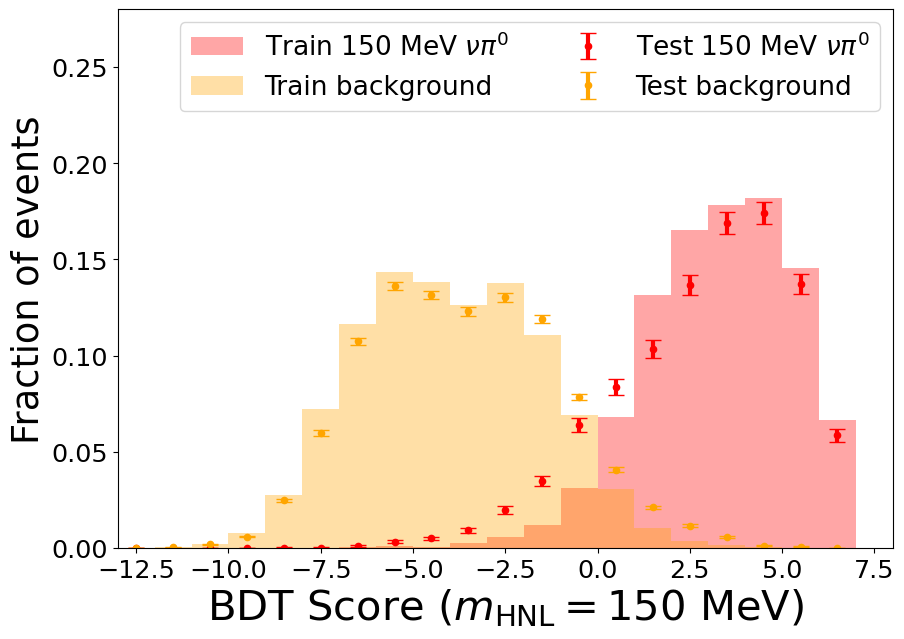

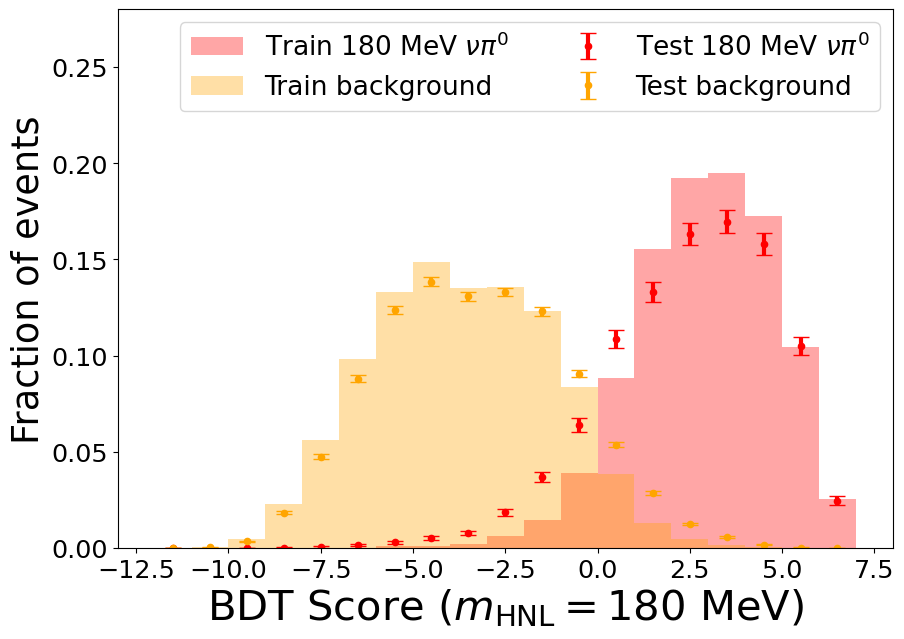

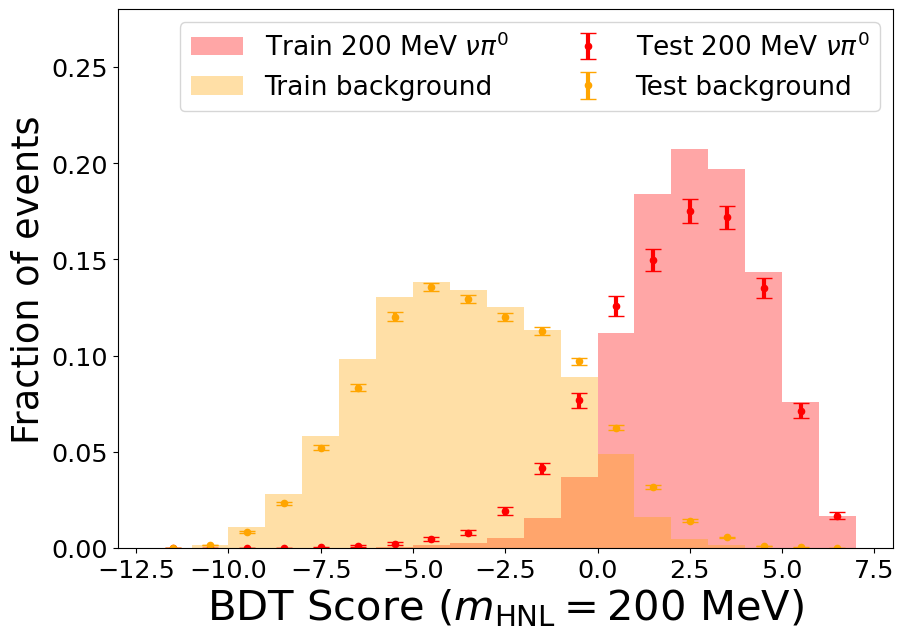

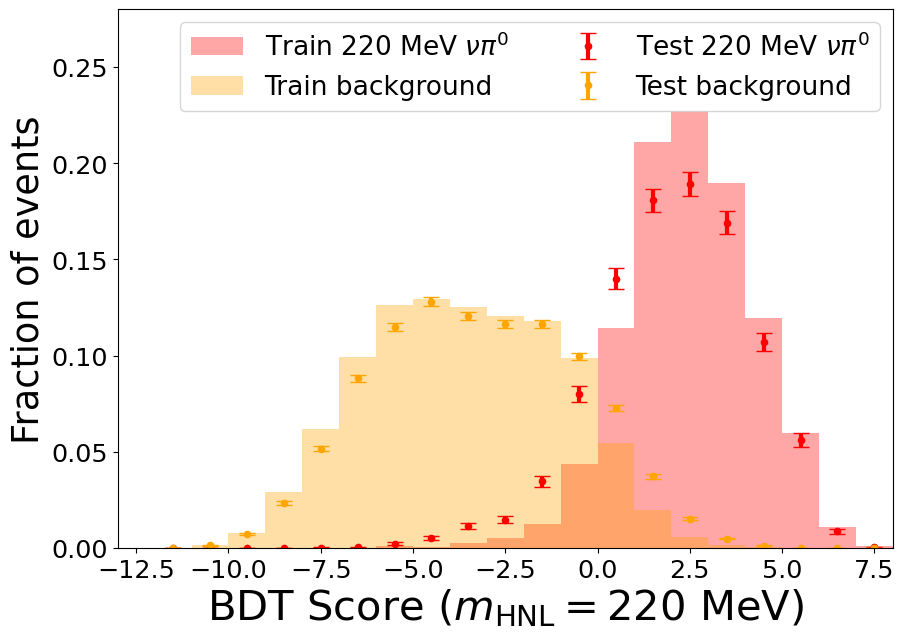

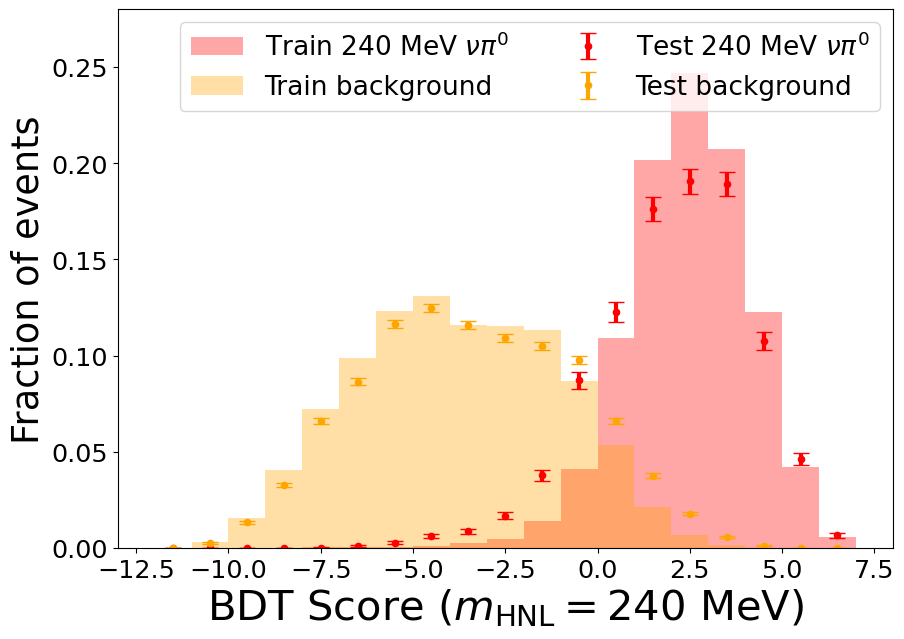

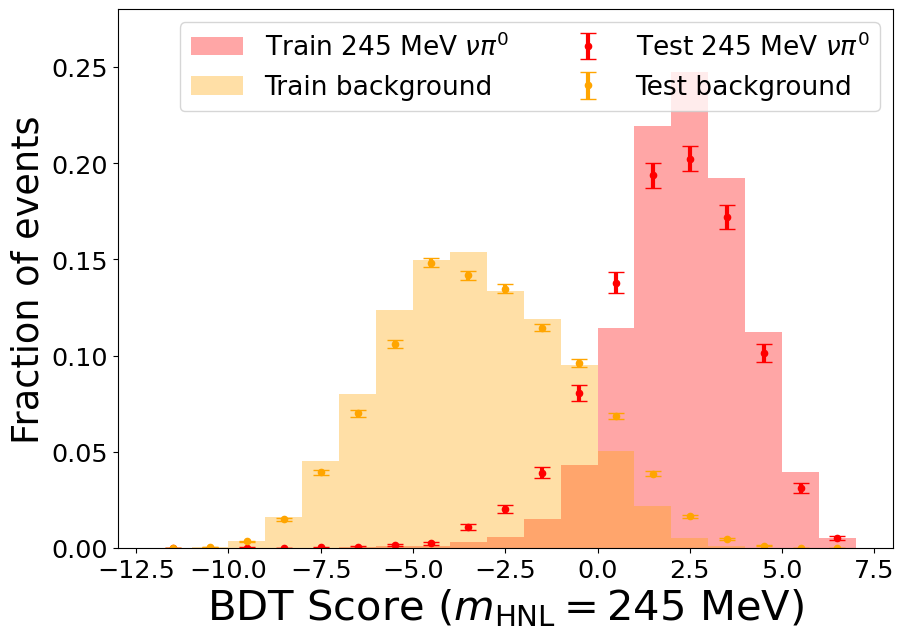

In [17]:
frac_test_signal, frac_train_signal, frac_test_bkg, frac_train_bkg=Test_vs_train_plots(xgb_sig_test_dict, xgb_test_bkg, xgb_sig_train_dict, xgb_train_bkg,bdt_model_dict, bins_dict, 
                    ymax=0.28, xlims=[-13,8], legsize=19, sig_region=4)


In [19]:
test_mass="150_pi0"

print("test frac:")
print(frac_test_signal[test_mass])
print("train frac:")
print(frac_train_signal[test_mass])
print("test bkg frac:")
print(frac_test_bkg[test_mass])
print("train bkg frac:")
print(frac_train_bkg[test_mass])
# frac_test_signal, frac_train_signal, frac_test_bkg, frac_train_bkg

test frac:
0.5387861736334405
train frac:
0.5772742935906272
test bkg frac:
0.007664811880458415
train bkg frac:
0.002213270771546191


overlay sum weights: 7516.480784881598
beamoff sum weights: 3763.7654304867906
dirt sum weights: 1049.3939581054508


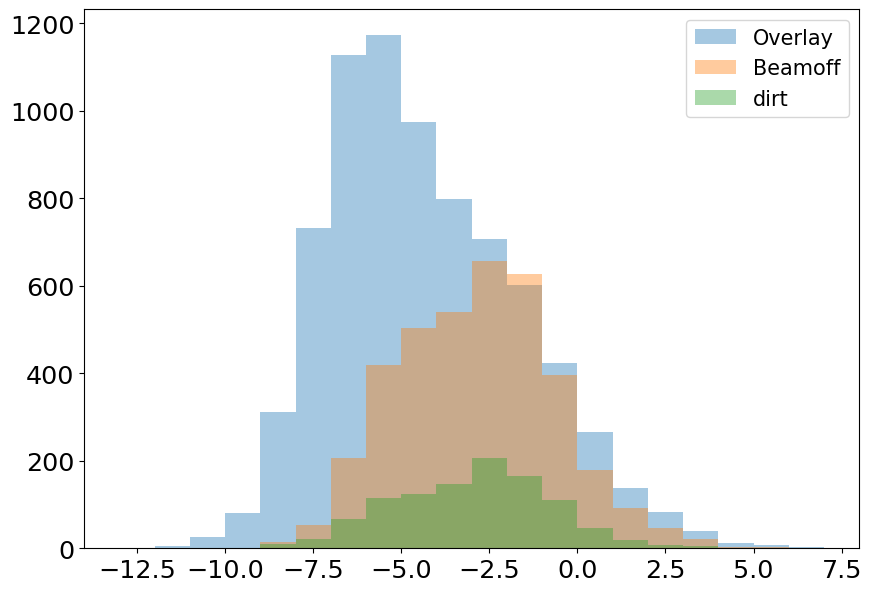

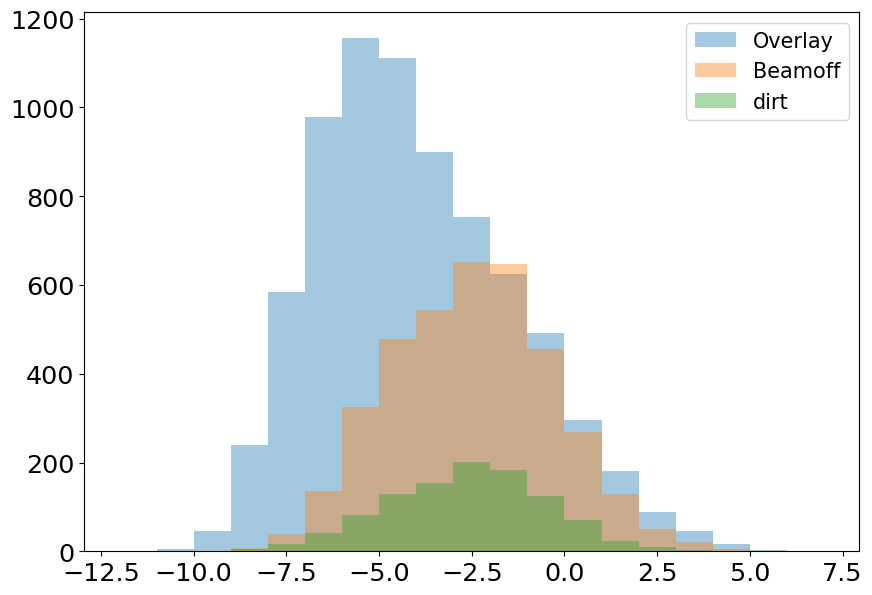

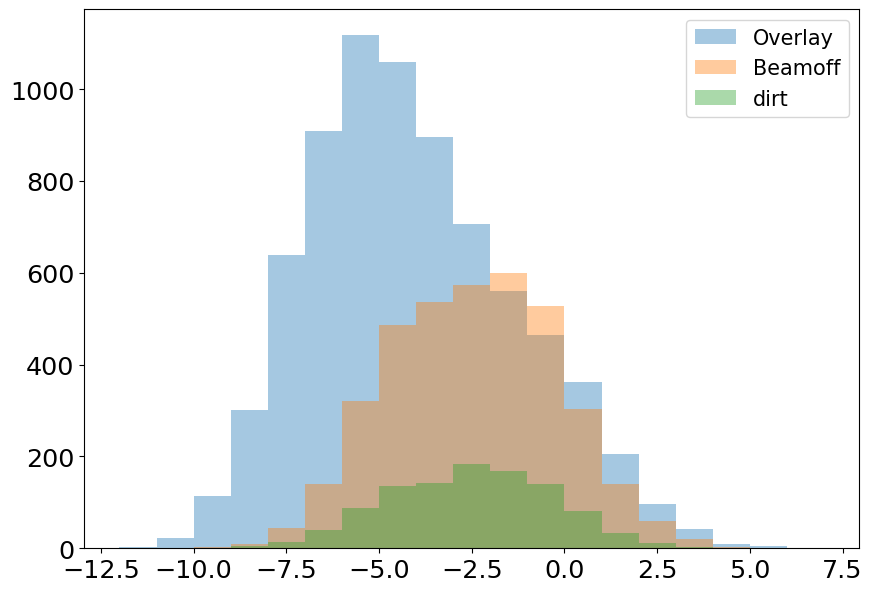

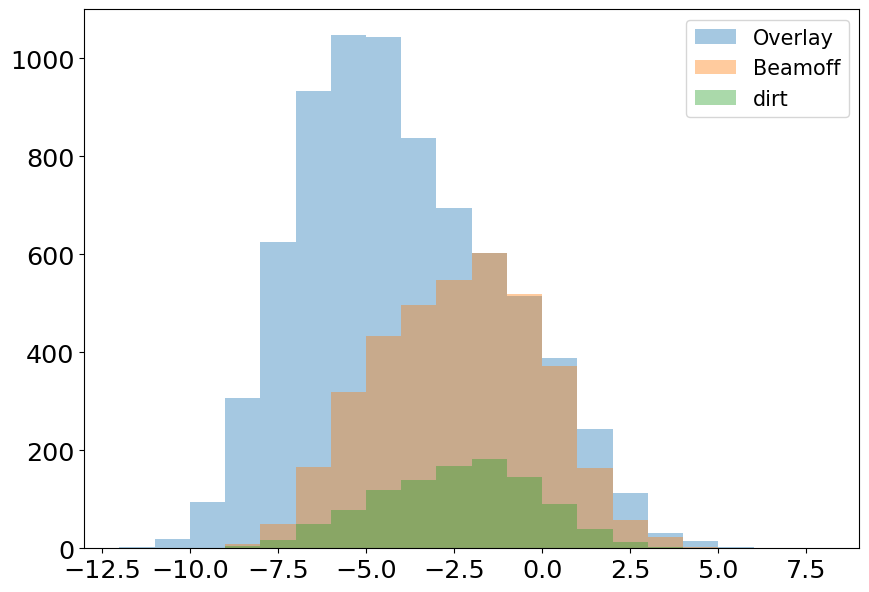

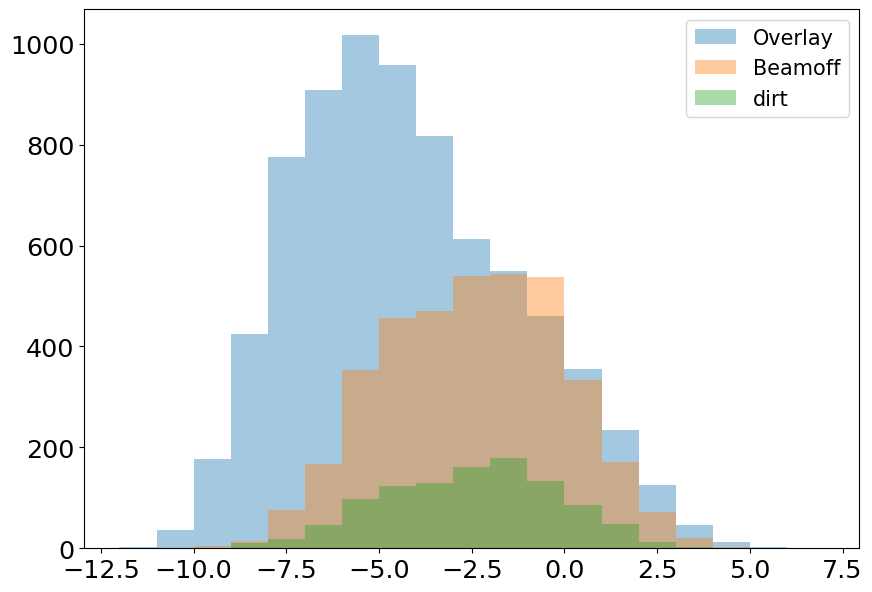

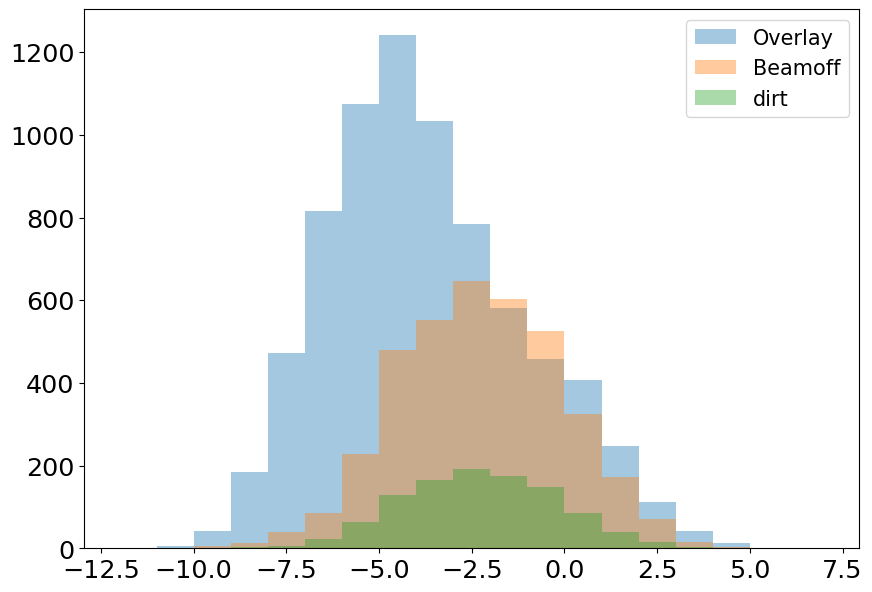

In [20]:
bkg_test_dists(xgb_overlay, xgb_beamoff, xgb_dirt, bdt_model_dict, bins_dict, sample_norms)


## ROC curves

In [21]:
print(len(overlay_test))
print(len(EXT_test))
print(len(dirt_test))

print(BDT_name)

14953
6092
1548
_full_Finished_8


In [22]:
# BDT_name = "_full_Finished"

sample_names = xgb_train_dict.keys()
sig_results_test_dict, bkg_results_test_dict = {}, {}
sig_results_train_dict, bkg_results_train_dict = {}, {}
overlay_test_results, beamoff_test_results, dirt_test_results = {}, {}, {}

if Params["Load_pi0_signal"]==False: sample_type = "ee"
if Params["Load_pi0_signal"]==True: sample_type = "pi0"

# xgb_overlay 
# xgb_beamoff 
# xgb_dirt

for HNL_mass in sample_names:
    # bdt = xgboost.Booster()
    if HNL_mass.split("_")[1] == "pi0": loc = "bdts/pi0_selection/"
    if HNL_mass.split("_")[1] == "ee": loc = "bdts/"
    # bdt.load_model(loc+Params["Run"]+f"_{HNL_mass}{BDT_name}.json")
    
    bdt = bdt_model_dict[HNL_mass]
    
    sig_results_test_dict[HNL_mass] = bdt.predict(xgb_sig_test_dict[HNL_mass])
    bkg_results_test_dict[HNL_mass] = bdt.predict(xgb_test_bkg)
    
    sig_results_train_dict[HNL_mass] = bdt.predict(xgb_sig_train_dict[HNL_mass])
    bkg_results_train_dict[HNL_mass] = bdt.predict(xgb_train_bkg)
    
    overlay_test_results[HNL_mass] = bdt.predict(xgb_overlay)
    beamoff_test_results[HNL_mass] = bdt.predict(xgb_beamoff)
    dirt_test_results[HNL_mass] = bdt.predict(xgb_dirt)
    
print(bdt_model_dict.keys())

dict_keys(['150_pi0', '180_pi0', '200_pi0', '220_pi0', '240_pi0', '245_pi0'])


In [23]:
# test = xgboost.load_config(bdt_model_dict["10_ee"])
for HNL_mass in bdt_model_dict:
    print(HNL_mass)
    print(bdt_model_dict[HNL_mass].num_boosted_rounds())

150_pi0
150
180_pi0
150
200_pi0
150
220_pi0
150
240_pi0
150
245_pi0
150


In [24]:
def RocCurves_test(test_sig,test_bkg,mass_label):
    """
    For plotting ROC curves of test samples only.
    """
    
    def PosRate(cut_val,var):
        return len(var[var>cut_val])/len(var)
    
    def NegRate(cut_val,var):
        return len(var[var<cut_val])/len(var)
    
    def CalcRate(sig,bkg):
        cuts=np.linspace(0,1,200)
        FPs=[]
        TPs=[]


        for cut in cuts:
            FPs.append(NegRate(cut,bkg))
            TPs.append(PosRate(cut,sig))

        FPs=np.array(FPs)
        TPs=np.array(TPs)

        AUC=-1.0*sum(((TPs[:-1]+TPs[1:])/2)*(FPs[:-1]-FPs[1:]))
        rounded_AUC = round(AUC,3)

        plt.plot(FPs,TPs,label=f'{mass_label} MeV, AUC={AUC:.{3}g}')
        # plt.plot(FPs,TPs,label=f'{mass_label} MeV, AUC={rounded_AUC}')
        
    CalcRate(test_sig,test_bkg)
    
def RocCurves_normalised(test_sig, sample_norms, test_overlay, test_beamoff, test_dirt, mass_label):
    """
    For plotting ROC curves of test samples only. 
    Correctly accounted for POT normalisation but not individual weights (effect minimal).
    """
    
    def PosRate(cut_val,var): #Fraction of signal events ABOVE cut_val
        return len(var[var>cut_val])/len(var)
    
    def NegRate(cut_val,overlay,beamoff,dirt): #Fraction of all bkg events BELOW cut_val (normalised, not weighted)
        num=(len(overlay[overlay<cut_val])*sample_norms["overlay"])+(len(beamoff[beamoff<cut_val])*sample_norms["beamoff"])+(len(dirt[dirt<cut_val])*sample_norms["dirtoverlay"])
        dom=(len(overlay)*sample_norms["overlay"])+(len(beamoff)*sample_norms["beamoff"])+(len(dirt)*sample_norms["dirtoverlay"])
        return num/dom
    
    def CalcRate(sig,overlay,beamoff,dirt):
        cuts=np.linspace(0,1,50)
        FPs=[]
        TPs=[]
        
        for cut in cuts:
            FPs.append(NegRate(cut,overlay,beamoff,dirt))
            TPs.append(PosRate(cut,sig))

        FPs=np.array(FPs)
        TPs=np.array(TPs)

        AUC=-1.0*sum(((TPs[:-1]+TPs[1:])/2)*(FPs[:-1]-FPs[1:]))
        rounded_AUC = round(AUC,3)

        plt.plot(FPs,TPs,label=f'{mass_label} MeV, AUC={AUC:.{3}g}')
        
    CalcRate(test_sig, test_overlay, test_beamoff, test_dirt)
    
def RocCurves_test_train(test_sig,test_bkg,train_sig,train_bkg, mass_label):
    """
    For plotting ROC curves of test samples only.
    """
    
    def PosRate(cut_val,var):
        return len(var[var>cut_val])/len(var)
    
    def NegRate(cut_val,var):
        return len(var[var<cut_val])/len(var)
    
    def CalcRate(sig,bkg,linestyle):
        cuts=np.linspace(0,1,200)
        FPs=[]
        TPs=[]


        for cut in cuts:
            FPs.append(NegRate(cut,bkg))
            TPs.append(PosRate(cut,sig))

        FPs=np.array(FPs)
        TPs=np.array(TPs)


        AUC=-1.0*sum(((TPs[:-1]+TPs[1:])/2)*(FPs[:-1]-FPs[1:]))
        rounded_AUC = round(AUC,3)
        
        plt.plot(FPs,TPs,label=f'{mass_label} MeV, AUC={AUC:.{3}g}',linestyle=linestyle)
        # plt.plot(FPs,TPs,label=f'{mass_label} MeV, AUC={rounded_AUC}')
        plt.xlabel("False Positives")
        plt.ylabel("True Positives")
        plt.legend()
        
        
    CalcRate(test_sig,test_bkg,linestyle="solid")
    CalcRate(train_sig,train_bkg,linestyle="dashed")


Do you want to save the Figure? y/n  n


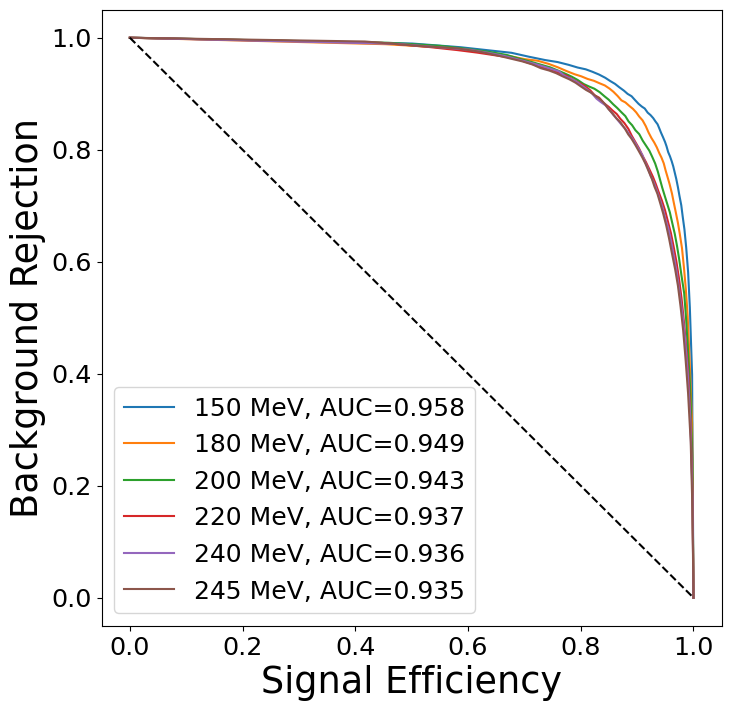

In [25]:
plt.figure(figsize=[8,8])

save_fig = input("Do you want to save the Figure? y/n ")

for HNL_mass in sig_results_test_dict:
    mass_label = HNL_mass.split("_")[0]
    if mass_label == "2": continue
    # RocCurves_test(sig_results_test_dict[HNL_mass],bkg_results_test_dict[HNL_mass], mass_label)
    RocCurves_normalised(sig_results_test_dict[HNL_mass], sample_norms, overlay_test_results[HNL_mass], beamoff_test_results[HNL_mass], 
                         dirt_test_results[HNL_mass], mass_label)
    
x_flat_line=np.linspace(0,1,50)
y_flat_line = []
for i, x in enumerate(x_flat_line):
    y_flat_line.append(1-x)
    
plt.plot(x_flat_line, y_flat_line, linestyle="dashed", color="black")
    
plt.xlabel("Signal Efficiency")
plt.ylabel("Background Rejection")
plt.legend(fontsize=18)

if save_fig == "y":
    plt.savefig(f"plots/BDT_output/BDT_performance/Test_set_normalised_ROC_" + Params["Run"] + f"_{sample_type}{BDT_name}.png")
    plt.savefig(f"plots/BDT_output/BDT_performance/Test_set_normalised_ROC_" + Params["Run"] + f"_{sample_type}{BDT_name}.pdf")


In [ ]:
plt.figure(figsize=[8,8])

save_fig = input("Do you want to save the Figure? y/n ")

for HNL_mass in sig_results_test_dict:
    mass_label = HNL_mass.split("_")[0]
    if mass_label == "2": continue
    RocCurves_test_train(sig_results_test_dict[HNL_mass],bkg_results_test_dict[HNL_mass],
                         sig_results_train_dict[HNL_mass],bkg_results_train_dict[HNL_mass], mass_label)
    
x_flat_line=np.linspace(0,1,200)
y_flat_line = []
for i, x in enumerate(x_flat_line):
    y_flat_line.append(1-x)
    
plt.plot(x_flat_line, y_flat_line, linestyle="dashed", color="black")
    
plt.xlabel("False Positives")
plt.ylabel("True Positives")
plt.legend(fontsize=19)

if save_fig == "y":
    plt.savefig(f"plots/BDT_output/BDT_performance/Test_and_train_ROC_" + Params["Run"] + f"_{sample_type}{BDT_name}.png")
    plt.savefig(f"plots/BDT_output/BDT_performance/Test_and_train_ROC_" + Params["Run"] + f"_{sample_type}{BDT_name}.pdf")

# Finished Training

## Checking variable correlations

In [ ]:
# bdt_vars = feature_names
HNL_mass = "150_ee"

In [ ]:
#Taken from Luis' code
# for HNL_mass in HNL_masses:
method = 'kendall'
correlations = signal_samples_dict[HNL_mass][bdt_vars].astype(np.float64).corr(method=method)
plt.figure(figsize=(15,12))
sns.heatmap(correlations,vmin=-1,annot=False,square=True,cbar_kws={'label':method+' correlation'},cmap = 'RdBu_r')
plt.title('Input Variable Correlations')
plt.show()

In [ ]:
#Just looking at most correlated 
corr=signal_samples_dict[HNL_mass][bdt_vars].corr()
high_corr_var=np.where(corr>0.999)
high_corr_var=[(corr.columns[x],corr.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
#high_corr_var
print("Done")

## Looking at feature importances

In [26]:
def Plot_feature_importances(model_dict, subset_samples, importance_type = "gain"):
    """
    Takes a dict of BDT models and plots feature importances for a subset of samples.
    """
    importance_dict = {}
    for HNL_mass in model_dict:
        importance = model_dict[HNL_mass].get_score(importance_type=importance_type)
        #sort them here
        sorted_importance = dict(sorted(importance.items(), key=lambda item: item[1]))
        sorted_importance_list = list(sorted_importance.values())
        sorted_importance_keys= list(sorted_importance.keys())
        importance_dict[HNL_mass] = importance
        
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    plt.figure(figsize=[20,8])
    
    for i, HNL_mass in enumerate(subset_samples):
        mass_label=HNL_mass.split("_")[0]
        sample_type = HNL_mass.split("_")[1]
        if sample_type == "ee": model_label = f"{mass_label} MeV " + r"$\nu e^{+}e^{-}$" + " model"
        if sample_type == "pi0": model_label = f"{mass_label} MeV " + r"$\nu \pi^{0}$" + " model"
        plt.bar(importance_dict[HNL_mass].keys(),importance_dict[HNL_mass].values(), label=model_label, 
        fill=False,linewidth=3, edgecolor=color_cycle[i])
        
    correct_names = []
    for var in importance_dict[HNL_mass].keys():
        correct_names.append(Constants.variable_no_units[var])

    # plt.xticks(np.array(range(0, len(importance_dict[HNL_mass].keys()))),importance_dict[HNL_mass].keys(),rotation=80)
    plt.xticks(np.array(range(0, len(importance_dict[HNL_mass].keys()))),correct_names,rotation=80)
    plt.ylabel("Importance")
    plt.legend(fontsize=20)
    plt.tight_layout()
        

Do you want to save the Figure? y/n  y


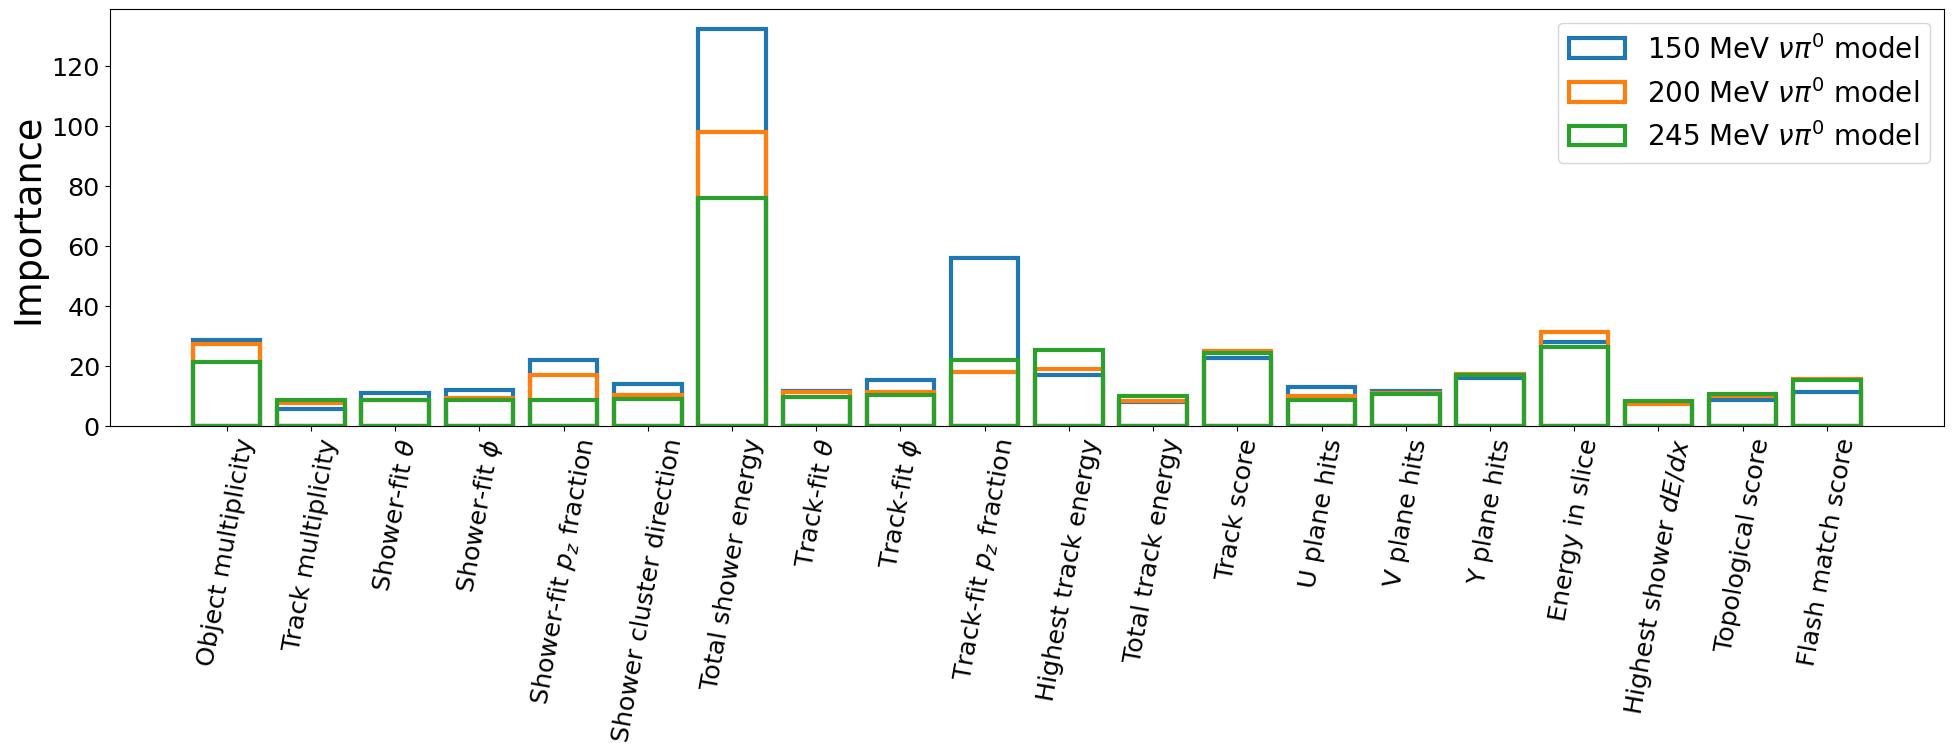

In [28]:
reload(Constants)
if sample_type == "ee": subset_samples = ["10_ee", "50_ee", "150_ee"]
if sample_type == "pi0": subset_samples = ["150_pi0", "200_pi0", "245_pi0"]
Plot_feature_importances(bdt_model_dict, subset_samples, importance_type = "gain")

save_fig = input("Do you want to save the Figure? y/n ")

if save_fig=="y":
    plt.savefig("plots/BDT_output/variable_importance/"+ Params["Run"]+f"_importances_{sample_type}{BDT_name}.pdf")
    plt.savefig("plots/BDT_output/variable_importance/"+ Params["Run"]+f"_importances_{sample_type}{BDT_name}.png")

# Finished code

In [ ]:
# dirt_matrix = xgboost.DMatrix(dirt_BDT[bdt_vars])
# EXT_matrix = xgboost.DMatrix(EXT_BDT[bdt_vars])

test_results_sig_dict = {}
test_results_bkg_dict = {}

train_results_sig_dict = {}
train_results_bkg_dict = {}

for HNL_mass in Constants.HNL_mass_samples:

    bdt = xgboost.Booster()
    bdt.load_model("bdts/"+Params["Run"]+f"_{HNL_mass}_MeV_New_20_variables_FIXED.json")
    #bdt.load_model(f'bdts/{Run}_{HNL_mass}_MeV_REDUCED_variables_flattened_highest_E_2.json')
    
    importance = bdt.get_score(importance_type="gain")
    
    for key in importance.keys():
        importance[key] = round(importance[key],1)
        
    #importance_dict[HNL_mass] = importance

    results_sig = bdt.predict(xgb_test_dict[HNL_mass])
    results_bkg = bdt.predict(xgb_test_bkg)
    
    train_results_sig = bdt.predict(xgb_sig_train_dict[HNL_mass])
    train_results_bkg = bdt.predict(xgb_bkg_train_dict[HNL_mass])
    
    test_results_sig_dict.update({HNL_mass:results_sig})
    test_results_bkg_dict.update({HNL_mass:results_bkg})
    
    train_results_sig_dict.update({HNL_mass:train_results_sig})
    train_results_bkg_dict.update({HNL_mass:train_results_bkg})

    # results_dirt = bdt.predict(dirt_matrix)
    # results_EXT = bdt.predict(EXT_matrix)
    
    # dirt_BDT[f'BDT_output_{HNL_mass}MeV'] = results_dirt
    # EXT_BDT[f'BDT_output_{HNL_mass}MeV'] = results_EXT

    # overlay_test_BDT[f'BDT_output_{HNL_mass}MeV'] = results_bkg
    # #Can add in a second loop over HNL_masses so that I predict each signal mass point with every other mass point bdt
    # signal_test_BDT_dict[HNL_mass][f'BDT_output'] = results_sig
    
    #Plotting importances of variables
    plt.figure(figsize=(12,12),facecolor='white')
    print(f"Plotting {HNL_mass}MeV importances:")
    a = xgboost.plot_importance(importance,max_num_features=10,importance_type='gain')
    

## Test vs. Train

In [ ]:
hist_range=[0,1.0]
n_bins=20

for HNL_mass in Constants.HNL_mass_samples:
    plt.figure(figsize=(10,7))
    plt.hist(train_results_sig_dict[HNL_mass],bins=n_bins, range=hist_range, density=True,alpha=0.4,color='red',label=f'Train {HNL_mass}MeV HNL' )
    counts,bin_edges = np.histogram(test_results_sig_dict[HNL_mass],bins=n_bins,range=hist_range,density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
    plt.plot(bin_centers,counts,marker='o',linestyle="None",color='red',label=f'Test {HNL_mass}MeV HNL')

    plt.hist(train_results_bkg_dict[HNL_mass], bins = n_bins, range = hist_range, density = True, alpha = 0.4, color = 'orange', label = r'Train overlay')
    counts,bin_edges = np.histogram(test_results_bkg_dict[HNL_mass],bins = n_bins, range= hist_range,density = True)
    bin_centers = (bin_edges[:-1] +  bin_edges[1:])/2.
    plt.plot(bin_centers,counts,marker='o',linestyle ="None",color='orange',label = r'Test overlay')
    plt.legend()

In [ ]:
#Make an importances dict   
def Top_N_vars(bdt_model, N_vars):
    importance = bdt.get_score(importance_type="gain")
    # for key in importance.keys():
    #     importance[key] = round(importance[key],1)
    sorted_importance = dict(sorted(importance.items(), key=lambda item: item[1]))
    sorted_importance_list = list(sorted_importance.values())
    sorted_importance_keys= list(sorted_importance.keys())
    top_N = sorted_importance_keys[-N_vars:]
    
    return top_N

def Sorted_importance(bdt_model):
    importance = bdt.get_score(importance_type="gain")
    return importance

top_N_dict = {}
importance_dict = {}
list_of_lists = []
# BDT_name = "ee_Finished"
# BDT_name = "pi0"

# if Params["Load_pi0_signal"] == False: 
#     sample_names = Constants.HNL_ee_samples_names
#     loc = "bdts/"
# if Params["Load_pi0_signal"] == True: 
#     sample_names = Constants.HNL_mass_pi0_samples_names #I should load BOTH
#     loc = "bdts/pi0_selection/"
sample_names = Constants.HNL_ee_samples_names #+ Constants.HNL_mass_pi0_samples_names
# for HNL_mass in Constants.HNL_mass_samples:
for HNL_mass in sample_names:
    bdt = xgboost.Booster()
    if HNL_mass.split("_")[1] == "pi0": loc = "bdts/pi0_selection/"
    if HNL_mass.split("_")[1] == "ee": loc = "bdts/"
    # bdt.load_model("bdts/"+Params["Run"]+f"_{HNL_mass}MeV_ultimate.json")
    # bdt.load_model("bdts/"+Params["Run"]+f"_{HNL_mass}MeV_{BDT_name}.json")
    bdt.load_model(loc+Params["Run"]+f"_{HNL_mass}{BDT_name}.json")
    # print("Number of entries in top20 is " + str(len(Top_N_vars(bdt, 20))))
    # top_N_dict[HNL_mass] = Top_N_vars(bdt, 20)
    top_N = Top_N_vars(bdt, 50)
    top_N_dict[HNL_mass] = Top_N_vars(bdt, 50)
    list_of_lists.append(Top_N_vars(bdt, 50))
    importance_dict[HNL_mass] = Sorted_importance(bdt)
    
elements_in_all = list(set.intersection(*map(set, list_of_lists)))
print(len(elements_in_all))
print(elements_in_all)

In [ ]:
highets_imps = ['n_showers', 'NeutrinoEnergy2', 'secondshower_Y_charge', 'trk_chipr_best', 'trk_energy_hits_tot', 'shr_energy_tot', 
                'contained_sps_ratio', 'pfnplanehits_Y', 'shrclusdir2', 'trk_dir_y_v', 'SliceCaloEnergy2', 'trk_theta_v', 'trk_start_x_v', 
                'pi0_radlen2', 'pfnplanehits_V', 'trk_energy', 'trk_score_v', 'shrclusdir0', 'trk_bragg_mip_v', 'shr_py_v', 
                'nu_flashmatch_score', 'n_pfps', 'CosmicIPAll3D', 'pi0_dir2_z']

ultimate_feature_list = ['n_pfps', 'n_tracks', 'shr_theta_v', 'shr_phi_v', 'shr_pz_v', 'shrclusdir2', 'shr_energy_tot',
                         'trk_theta_v', 'trk_phi_v','trk_dir_z_v', 'trk_energy', 'trk_energy_tot', 'trk_calo_energy_u_v', 'trk_score_v',
                         'pfnplanehits_U', 'pfnplanehits_V', 'pfnplanehits_Y', 'NeutrinoEnergy2', 'nu_flashmatch_score']

elements_in_all = list(set.intersection(*map(set, [highets_imps,ultimate_feature_list])))
print(len(elements_in_all))
print(elements_in_all)

In [ ]:
print(importance_dict[245].keys())
print(len(importance_dict[245].keys()))

In [ ]:
# for HNL_mass in Constants.HNL_mass_samples:
savefig = False
plt.figure(figsize=[20,8])
if Params["Load_pi0_signal"] == True: 
    colours = {"150_pi0":"coral", "200_pi0":"cornflowerblue", "245_pi0":"olivedrab"}
    smaller_samples = ["150_pi0", "200_pi0", "245_pi0"]
if Params["Load_pi0_signal"] == False: 
    colours = {"10_ee":"coral", "100_ee":"cornflowerblue", "150_ee":"olivedrab"}
    smaller_samples = ["10_ee", "100_ee", "150_ee"]
    
smaller_samples = ["10_ee", "100_ee", "150_ee"]#,"150_pi0", "200_pi0", "245_pi0"]
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, HNL_mass in enumerate(smaller_samples):
    plt.bar(importance_dict[HNL_mass].keys(),importance_dict[HNL_mass].values(), label=f"{HNL_mass} model", 
            fill=False,linewidth=3, edgecolor=color_cycle[i])
    # plt.bar(importance_dict[HNL_mass].keys(),importance_dict[HNL_mass].values(), label=f"{HNL_mass}MeV model", 
    #         fill=False,linewidth=3, edgecolor=colours[HNL_mass], color=colours[HNL_mass])
# plt.bar(importance_dict[245].keys(),importance_dict[245].values())
plt.xticks(np.array(range(0, len(importance_dict[HNL_mass].keys()))),importance_dict[HNL_mass].keys(),rotation=80)
plt.ylabel("Importance")
plt.legend(fontsize=20)
plt.tight_layout()

if savefig==True:
    plt.savefig("plots/BDT_output/variable_importance/"+ Params["Run"]+f"_importances{BDT_name}.pdf")
    plt.savefig("plots/BDT_output/variable_importance/"+ Params["Run"]+f"_importances{BDT_name}.png")

In [ ]:
plt.figure(figsize=[20,8])
colours = {150:"coral", 200:"cornflowerblue", 245:"olivedrab"}
for HNL_mass in [245]:
    plt.bar(importance_dict[HNL_mass].keys(),importance_dict[HNL_mass].values(), label=f"{HNL_mass}MeV model", 
            fill=False,linewidth=3, edgecolor=colours[HNL_mass], color=colours[HNL_mass])
# plt.bar(importance_dict[245].keys(),importance_dict[245].values())
plt.xticks(np.array(range(0, len(importance_dict[HNL_mass].keys()))),importance_dict[HNL_mass].keys(),rotation=80)
plt.ylabel("Importance")
plt.legend(fontsize=20)
plt.tight_layout()

# plt.savefig("plots/BDT_output/variable_importance/"+ Params["Run"]+f"_importances_{BDT_name}.pdf")
# plt.savefig("plots/BDT_output/variable_importance/"+ Params["Run"]+f"_importances_{BDT_name}.png")

In [ ]:
fig = plt.figure(figsize=[20,20])
ax1 = fig.add_subplot(projection='3d')

mass_list = ["2MeV", "100MeV", "245MeV"]
x = importance_dict[2].keys()
y = mass_list
data = np.array([list(importance_dict[2].values()),
                 list(importance_dict[100].values()),
                 list(importance_dict[245].values())])

numOfCols = len(x)
numOfRows = len(y)

xpos = np.arange(0, numOfCols, 1)
ypos = np.arange(0, numOfRows, 1)
xpos, ypos = np.meshgrid(xpos + 0.5, ypos + 0.5)

xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros(numOfCols * numOfRows)

dx = np.ones(numOfRows * numOfCols) * 0.5
dy = np.ones(numOfCols * numOfRows) * 0.5
dz = data.flatten()

mass_list_labels = [" "," ", "2MeV"," ", "100MeV"," ", "245MeV"]

ax1.bar3d(xpos, ypos, zpos, dx, dy, dz)
ax1.set_xticklabels(list(importance_dict[2].keys()),rotation=45)
# ax1.set_xticklabels(list(importance_dict[2].keys()))
ax1.set_yticklabels(mass_list_labels)

ax1.set_xlabel('Variable')
ax1.set_ylabel('Model')
ax1.set_zlabel('Importance')
# plt.show()

## Checking variable correlations

In [ ]:
Presel_overlay.keys()

signal_samples_dict['10_ee']

In [ ]:
#Taken from Luis' code
# for HNL_mass in HNL_masses:

method = 'kendall'
correlations = Presel_overlay[bdt_vars].astype(np.float64).corr(method=method)
plt.figure(figsize=(15,12))
sns.heatmap(correlations,vmin=-1,annot=False,square=True,cbar_kws={'label':method+' correlation'},cmap = 'RdBu_r')
plt.title('Input Variable Correlations')
plt.show()

In [ ]:
print(correlations)

In [ ]:
#Just looking at most correlated 
# corr=cleaned_signal_dict[100][bdt_vars].corr()
high_corr_var=np.where(correlations>0.8)
high_corr_var=[(correlations.columns[x],correlations.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
high_corr_var

# End of code